In [1]:
import duckdb
import pandas as pd

db = duckdb.connect()

# Use forward slashes (works on Windows too)
MADOC_PATH = "D:/Varun Kumar/Proejekt/Data/processed/madoc_all.parquet"


In [2]:
db.execute(f"""
SELECT COUNT(*) AS n_rows
FROM read_parquet('{MADOC_PATH}')
""").fetchdf()


,n_rows
0,20674267


In [ ]:
# Creating the table which we will be working with for our analysis

query = f"""
CREATE OR REPLACE TABLE madoc_core AS
SELECT 
    post_id,
    platform,
    community,
    publish_ts,
    year,
    content
FROM read_parquet('{MADOC_PATH}')
WHERE language = 'English'
"""
db.execute(query)


In [4]:
db.execute("SELECT COUNT(*) FROM madoc_core").fetchdf()


,count_star()
0,20674267


In [ ]:
# Adding month column

db.execute("""
ALTER TABLE madoc_core
ADD COLUMN month DATE
""")

db.execute("""
UPDATE madoc_core
SET month = DATE_TRUNC('month', publish_ts)
""")


In [7]:
db.execute("""
SELECT 
    COUNT(*) AS rows,
    MIN(month) AS start,
    MAX(month) AS end
FROM madoc_core
""").fetchdf()


,rows,start,end
0,20674267,2014-01-01,2021-01-01


In [8]:
db.execute("""
SELECT platform, COUNT(*) 
FROM madoc_core 
GROUP BY platform
""").fetchdf()


,platform,count_star()
0,reddit,19960037
1,voat,714230


### Platform migration curves

In [ ]:
volume = db.execute("""
SELECT
    month,
    platform,
    COUNT(*) AS posts
FROM madoc_core
GROUP BY month, platform
ORDER BY month
""").fetchdf()


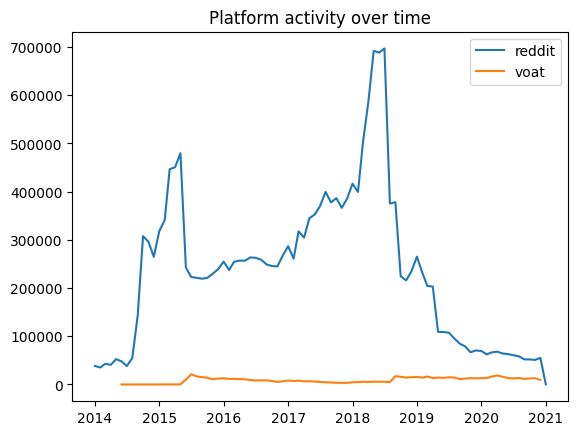

In [11]:
import matplotlib.pyplot as plt

for p in volume['platform'].unique():
    subset = volume[volume['platform'] == p]
    plt.plot(subset['month'], subset['posts'], label=p)

plt.legend()
plt.title("Platform activity over time")
plt.show()


### Community-level dynamics

In [16]:
community_volume = db.execute("""
SELECT
    month,
    platform,
    community,
    COUNT(*) AS posts
FROM madoc_core
GROUP BY month, platform, community
""").fetchdf()


In [17]:
core_communities = [
    "CringeAnarchy",
    "fatpeoplehate",
    "greatawakening",
    "MensRights",
    "KotakuInAction",
    "milliondollarextreme"
]

cv = community_volume[community_volume['community'].isin(core_communities)]


In [14]:
cv = cv.sort_values("month")


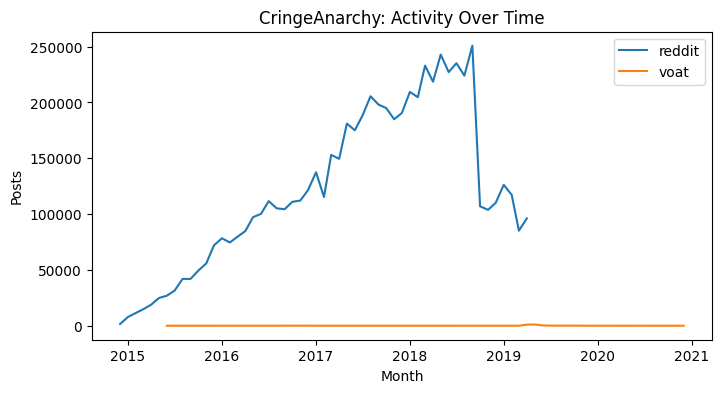

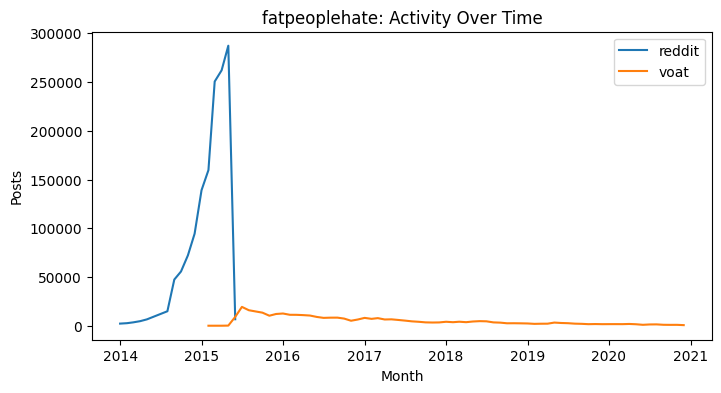

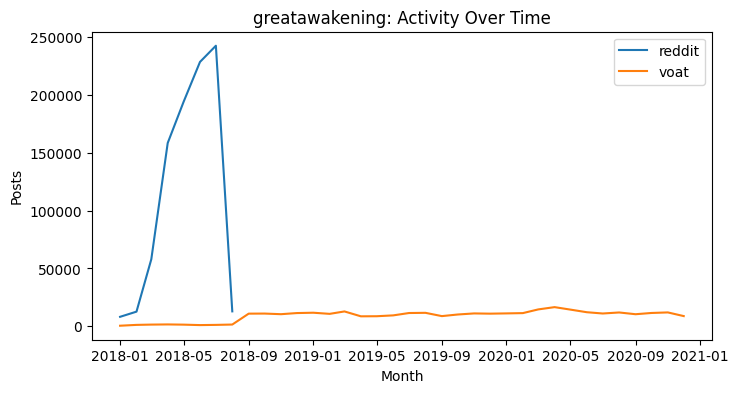

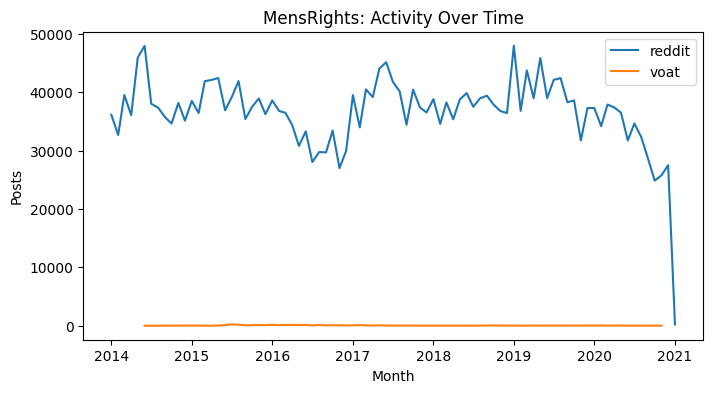

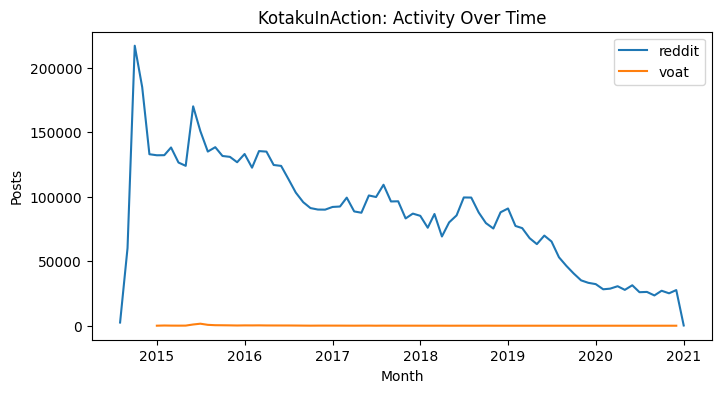

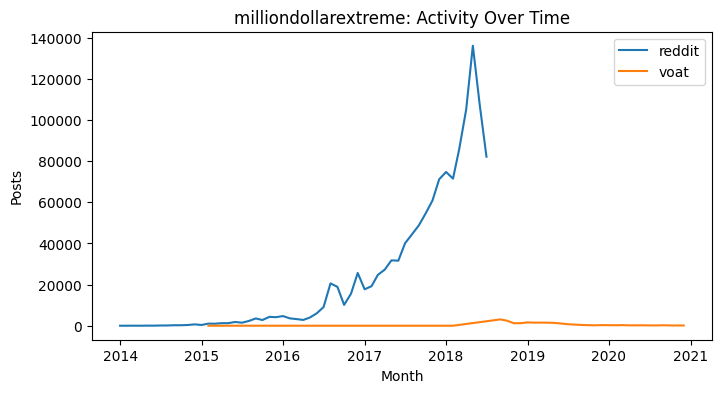

In [15]:
import matplotlib.pyplot as plt

for community in core_communities:
    plt.figure(figsize=(8,4))
    
    subset = cv[cv['community'] == community]
    
    for platform in subset['platform'].unique():
        plat = subset[subset['platform'] == platform]
        plt.plot(plat['month'], plat['posts'], label=platform)
    
    plt.title(f"{community}: Activity Over Time")
    plt.xlabel("Month")
    plt.ylabel("Posts")
    plt.legend()
    plt.show()


### Community-wise platform comparison

In [24]:
platform_share = db.execute("""
SELECT
    community,
    platform,
    COUNT(*) AS posts
FROM madoc_core
GROUP BY community, platform
""").fetchdf()


In [25]:
top_communities = (
    platform_share.groupby("community")["posts"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

ps = platform_share[platform_share["community"].isin(top_communities)]


In [26]:
ps["total"] = ps.groupby("community")["posts"].transform("sum")
ps["share"] = ps["posts"] / ps["total"]


In [27]:
pivot = ps.pivot(index="community", columns="platform", values="share").fillna(0)


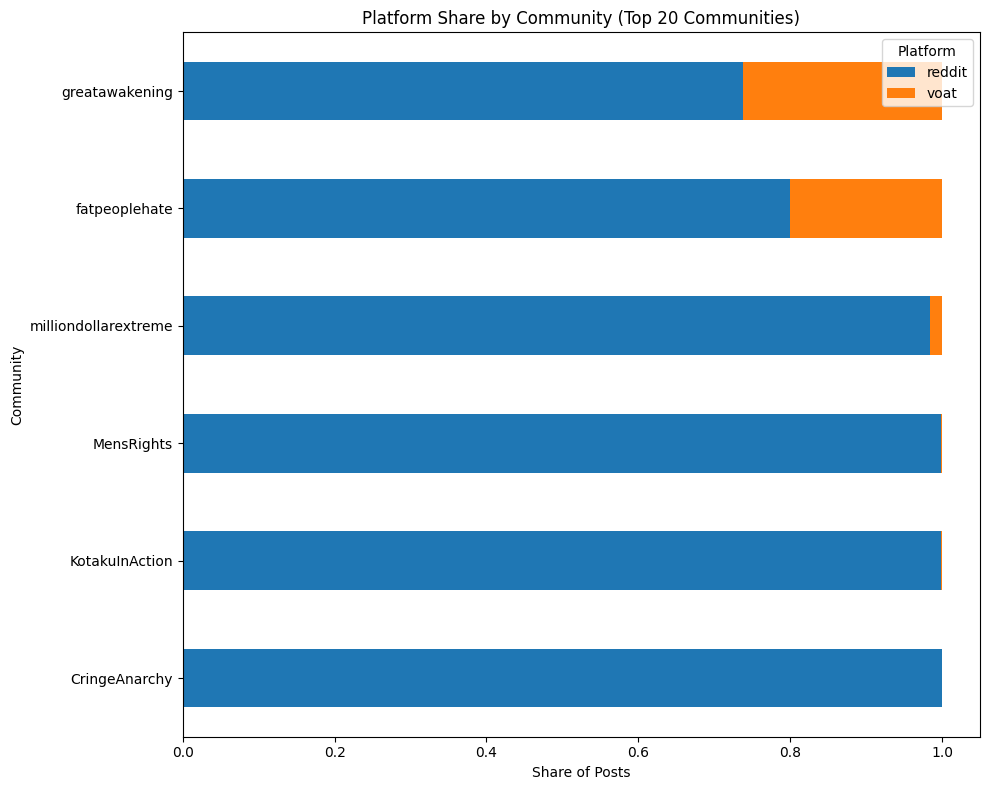

In [29]:
pivot.sort_values(by=pivot.columns[0], ascending=False).plot(
    kind="barh",
    stacked=True,
    figsize=(10,8)
)

plt.title("Platform Share by Community (Top 20 Communities)")
plt.xlabel("Share of Posts")
plt.ylabel("Community")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()


### Community Lead–Lag Between Reddit and Voat

In [30]:
comm_plat_ts = db.execute("""
SELECT
    month,
    community,
    platform,
    COUNT(*) AS posts
FROM madoc_core
GROUP BY month, community, platform
""").fetchdf()


In [31]:
pivot = (
    comm_plat_ts
    .pivot_table(index=["community","month"],
                 columns="platform",
                 values="posts",
                 fill_value=0)
    .reset_index()
)


In [33]:
pivot["reddit_s"] = pivot.groupby("community")["reddit"].transform(lambda x: x.rolling(3, min_periods=1).mean())
pivot["voat_s"]   = pivot.groupby("community")["voat"].transform(lambda x: x.rolling(3, min_periods=1).mean())


In [34]:
def lead_lag(group):
    if group["reddit_s"].sum() == 0 or group["voat_s"].sum() == 0:
        return None
    
    r_peak = group.loc[group["reddit_s"].idxmax()]["month"]
    v_peak = group.loc[group["voat_s"].idxmax()]["month"]
    
    return (v_peak - r_peak).days / 30

lags = pivot.groupby("community").apply(lead_lag).dropna()


C:\Users\Varun Pravesh\AppData\Local\Temp\ipykernel_22804\2247470534.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lags = pivot.groupby("community").apply(lead_lag).dropna()


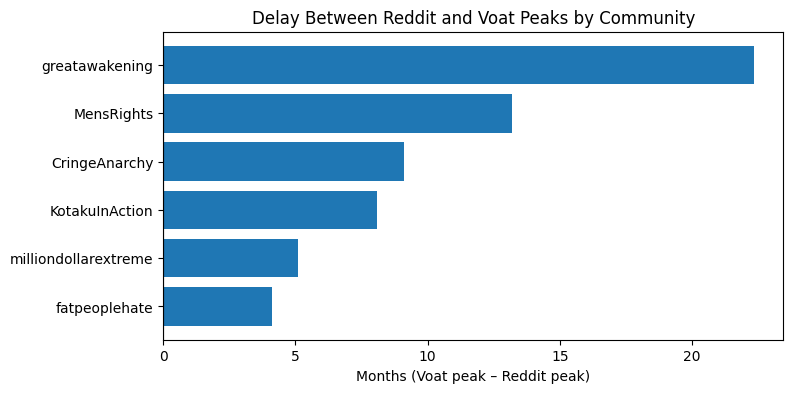

In [36]:
lag_df = lags.reset_index(name="lag")

lag_df = lag_df.sort_values("lag")

plt.figure(figsize=(8,4))
plt.barh(lag_df["community"], lag_df["lag"])
plt.axvline(0, color="black")
plt.xlabel("Months (Voat peak – Reddit peak)")
plt.title("Delay Between Reddit and Voat Peaks by Community")
plt.show()


### Platform Dominance Over Time (Who “owns” each community?)

In [46]:
share_ts = db.execute("""
SELECT
    month,
    community,
    platform,
    COUNT(*) AS posts
FROM madoc_core
GROUP BY month, community, platform
""").fetchdf()

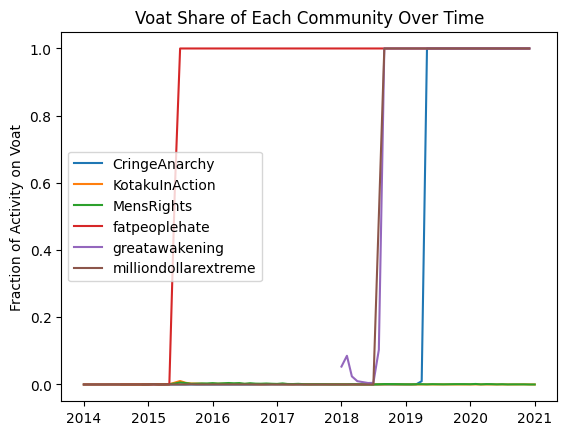

In [47]:
pivot = share_ts.pivot_table(
    index=["community","month"],
    columns="platform",
    values="posts",
    fill_value=0
).reset_index()

pivot["voat_share"] = pivot["voat"] / (pivot["voat"] + pivot["reddit"])

for c in pivot["community"].unique():
    sub = pivot[pivot["community"] == c]
    plt.plot(sub["month"], sub["voat_share"], label=c)

plt.legend()
plt.title("Voat Share of Each Community Over Time")
plt.ylabel("Fraction of Activity on Voat")
plt.show()


### Community Synchronisation

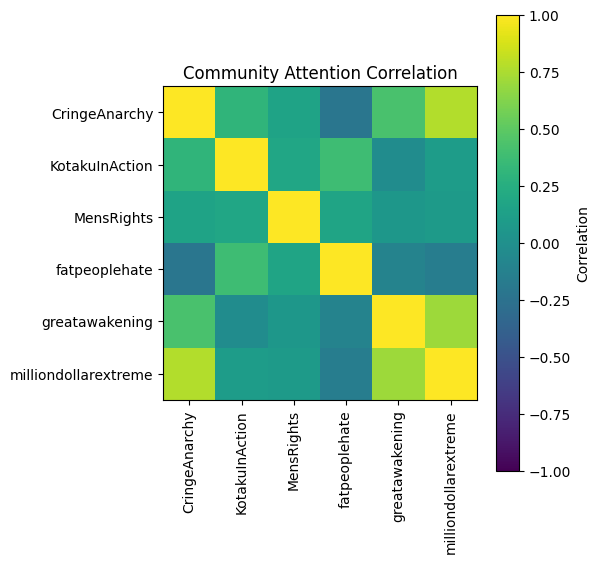

In [45]:
wide = total_ts.pivot(index="month", columns="community", values="posts").fillna(0)
corr = wide.corr()

plt.figure(figsize=(6,6))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(label="Correlation")

# Add labels
communities = corr.columns.tolist()
plt.xticks(range(len(communities)), communities, rotation=90)
plt.yticks(range(len(communities)), communities)

plt.title("Community Attention Correlation")
plt.tight_layout()
plt.show()
